In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Le but est de créer un réseau de neurones à Spike et de tester l'effet de l'introduction de délai  hétéro synaptique sur la sortie du réseau. L'idée de base est de créer des délais qui sont fixées de telle sorte qu'un pattern du signal va créer une synchronie au niveau postsynaptique et donc une sensibilité plus élevé pour les pattern qui sont appris apr rapport au bruit.


Pour simplifier le problème on va considérer une topologie mono dimensionnelle en anneau. Un certain nombre de neurones vont couvrir uniformément le cercle unitaire, ce qui est une bonne approximation de la représentation des orientations dans une macro colonne du cortex visuel primaire. Toujours pour simplifier on va connecter ses neurones d'entrée avec des neurones de sortie organisée suivant la même topologie. 


# generating a synthetic input with an activity dependent delay

Dans un premier temps on va modéliser une entrée synaptique avec une sélectivité à l'orientation comme une gaussienne sur l'espace circulaire, c'est-à-dire une distribution de von Mises. Comme montré dans les résultats de Celebrini, une entrée plus forte génère une latence plus courte. La relation est connue analytiquement et permet de générer un front d'activation aussi bien au niveau de l'activité que de la latence de décharge.


In [2]:
%mkdir -p LSD

In [3]:
%%writefile LSD/__init__.py

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import pyNN.nest as sim
from pyNN.utility import init_logging
init_logging(logfile=None, level=35)
from pyNN.random import RandomDistribution, NumpyRNG

# === Define parameters ========================================================
dt         = 0.5           # (ms)
simtime    = 3000.0        # (ms)
simtime    = 20000.0        # (ms)
simtime_show = 900.0      # (ms)

N_inputs = 60
N_inputs = 180
t_start = simtime_show/10.
tau_stim = 250. # interval between two stimulations
N_starts = simtime // tau_stim

t_starts = np.linspace(t_start, simtime-tau_stim-t_start, int(N_starts))

N_scan = 9
N_scan = 5

lambda_n = 10. # (Hz) rate of poisson noise
weight_0, delay_0, delay_min = 10.0, 25., 1.
inh_gain = 1.

theta = .50 # in units of a period
A_true = 1.5
B_true = .5 # tuning of the input signal
tau = 25.

figsize = (21, 13)
figsize = (15, 8)

Overwriting LSD/__init__.py


In [4]:
import LSD

## tuning curves on circular space: von Mises + latency code

In [5]:
%%writefile LSD/tuning.py

from .__init__ import *

def vonmises(N_inputs, theta=theta, B=B_true):
    return np.exp((np.cos(2*np.pi*(np.linspace(0, 1, N_inputs)-theta))-1)/B**2)

# TODO : show analog synaptic input
# https://en.wikipedia.org/wiki/Von_Mises_distribution

# TODO : compute latencies from a DC current injection
# TODO : move the patterns / use dynamic patterns ?
def get_latency(spike_times, current, tau=tau, t_start=100.):
    N_inputs = current.size
    if spike_times is None:
        spike_times = []
        for i_input in range(N_inputs):
            spike_times.append([])
            
    for i_input in range(N_inputs):
        if current[i_input] > 1:
            spike_time = t_start + tau * np.log(1/(1 - 1/current[i_input]))
            spike_times[i_input].append(spike_time)
            
    return spike_times

def celebrini(N_inputs, A=A_true, theta=theta, B=B_true, tau=tau, t_starts=t_starts, verbose=False):
    # https://www.cambridge.org/core/journals/visual-neuroscience/article/dynamics-of-orientation-coding-in-area-v1-of-the-awake-primate/906FA662AD71B432EB6D4F10795A397A
    
    current = A * vonmises(N_inputs, theta=theta, B=B)
    if verbose : print('current.max()', current.max())

    spike_times = None
    for t_start in t_starts:
        spike_times = get_latency(spike_times, current, tau=tau, t_start=t_start)
    if verbose : print('spike_times', spike_times)
    spike_source = sim.SpikeSourceArray(spike_times=spike_times)
    
    return spike_source



Overwriting LSD/tuning.py


In [6]:
from LSD.tuning import *
spike_source = celebrini(N_inputs, verbose=False)

## simulating using pyNN + nest

A dummy simulation to check the representation of input spikes within pyNN:

In [7]:
# === Build the network ========================================================
sim.setup(timestep=dt)
spike_source = celebrini(N_inputs, verbose=False)
spike_in = sim.Population(N_inputs, spike_source, label='input')
spike_in.record('spikes')

# === Run simulation ===========================================================
sim.run(simtime)
sim.end()
    

In [8]:
sts = spike_in.get_data().segments[0].spiketrains
st = sts[0]

In [9]:
st

SpikeTrain
annotations: {'source_population': 'input',
  'source_id': 183,
  'source_index': 0}

## plotting code

In [10]:
%%writefile LSD/plot.py

from .__init__ import *

def plot_spiketrains(spiketrains, simtime=None, simtime_show=None, fig=None, ax=None, 
                     marker='|', color='r', linelengths=0.9, alpha=1, verbose=False):
    """
    Plot all spike trains from a Segment into a raster plot.
    
    marker size is in points.
    
    """
    if fig is None:
        fig, ax = plt.subplots(figsize = (12, 8))
    if ax is None:
        ax = fig.subplot(1, 1)
    
    if simtime is None:
        from quantities import ms
        simtime = spiketrains[0].t_stop / ms
    if simtime_show is None:
        simtime_show = simtime

    ax.eventplot([np.array(spiketrain) for spiketrain in spiketrains], 
          colors=color, lineoffsets=1, linelengths=linelengths, alpha=alpha);
    ax.set_ylabel("Neuron index")
    ax.set_xlabel('Time(ms)')
    ax.set_xlim(0, simtime_show)
    min_index, max_index = 0, len(spiketrains)
    ax.set_yticks(np.linspace(min_index, max_index, 7, endpoint=True))
    ax.set_ylim(-0.5 + min_index, max_index + 0.5)
    return fig, ax


def spike_count_per_neuron(pop):
    sc = pop.get_spike_counts()
    return np.array([sc[i] for i in pop.all_cells])

def color(i=0, sat=1):
    c = [0, 0, 0]
    c[i] = sat 
    return c

def histogram(output, fig=None, ax=None, sat=1, lw=1, label='tc_cells'):
    if fig is None:
        fig, ax = plt.subplots(figsize = (12,8))
    if ax is None:
        ax = fig.subplot(1, 1)
    ax.plot(spike_count_per_neuron(output['noise_E'])/simtime, color=color(0, sat/2), lw=lw)
    ax.plot(spike_count_per_neuron(output['noise_I'])/simtime, color=color(0, 1/2+ sat/2), lw=lw)
    ax.plot(spike_count_per_neuron(output['spike_input'])/simtime, color=color(1, sat), lw=lw)
    ax.plot(spike_count_per_neuron(output['tc_cells'])/simtime, color=color(2, sat), lw=lw, label=label)
    ax.set_xticks(np.linspace(0, N_inputs, 7, endpoint=True))
    return fig, ax


Overwriting LSD/plot.py


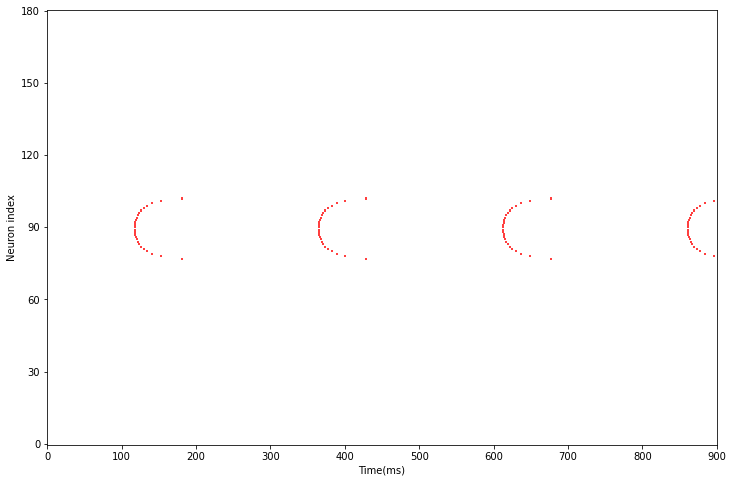

In [11]:
from LSD.plot import *
spiketrains = spike_in.get_data().segments[0].spiketrains
fig, ax = plot_spiketrains(spiketrains, simtime_show=simtime_show, color='r')

## effect of input's amplitude

A=0.871
A=1.253
A=1.803
A=2.594
A=3.732
A=5.370
A=7.727
A=11.119
A=16.000


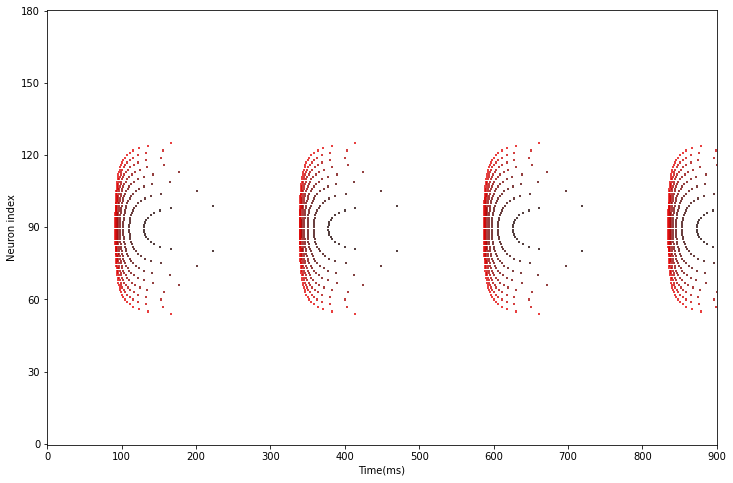

In [12]:
fig, ax = plt.subplots(figsize = (12,8))
N_scan = 9
for i_scan, A in enumerate(np.logspace(-.1, 2, N_scan, base=4)):
    sim.setup(timestep=dt)
    print(f'{A=:.3f}')
    spike_source = celebrini(N_inputs, A=A)
    spike_in = sim.Population(N_inputs, spike_source)
    spike_in.record('spikes')

    # === Run simulation ===========================================================

    sim.run(simtime)
    sim.end()
    spiketrains = spike_in.get_data().segments[0].spiketrains
    fig, ax = plot_spiketrains(spiketrains, color=(i_scan/N_scan, 0, 0), simtime_show=simtime_show, fig=fig, ax=ax)


Dans notre modèle d'entrée, chaque pattern génère un spike et un seul par neurone. Par contre, la forme du front de Spike dépend de l'amplitude de cette entrée.

## effect of input's tuning

B=0.250
B=0.354
B=0.500
B=0.707
B=1.000
B=1.414
B=2.000
B=2.828
B=4.000


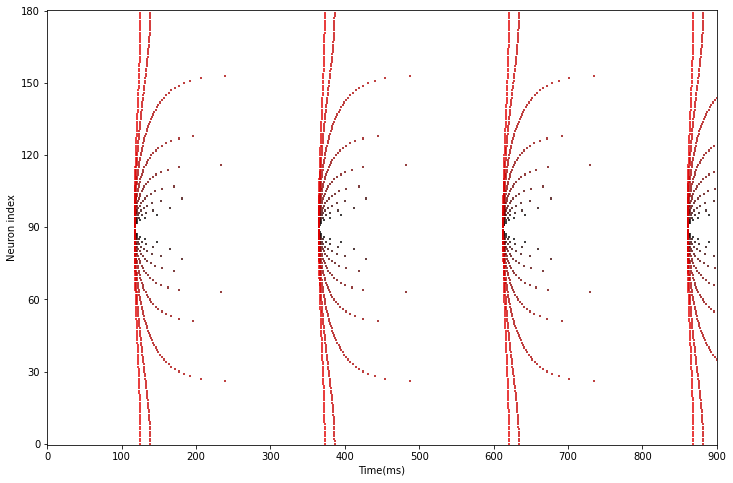

In [13]:
fig, ax = plt.subplots(figsize = (12,8))
for i_scan, B in enumerate(np.logspace(-1, 1, N_scan, base=4)):
    sim.setup(timestep=dt)
    print(f'{B=:.3f}')
    spike_source = celebrini(N_inputs, B=B, verbose=False)
    spike_in = sim.Population(N_inputs, spike_source)
    spike_in.record('spikes')

    # === Run simulation ===========================================================
    sim.run(simtime)
    sim.end()
    spiketrains = spike_in.get_data().segments[0].spiketrains
    fig, ax = plot_spiketrains(spiketrains, color=(i_scan/N_scan, 0, 0), simtime_show=simtime_show, fig=fig, ax=ax)


## effect of input's mode (central orientation)

theta=0.000
theta=0.125
theta=0.250
theta=0.375
theta=0.500
theta=0.625
theta=0.750
theta=0.875
theta=1.000


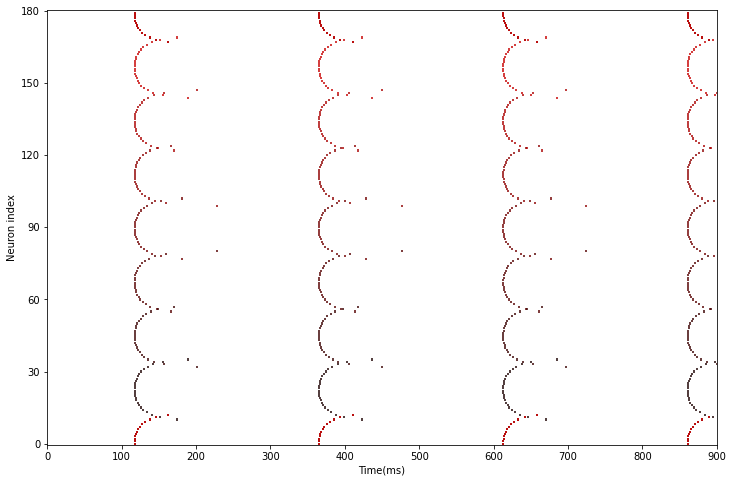

In [14]:
fig, ax = plt.subplots(figsize = (12,8))
for i_scan, theta in enumerate(np.linspace(0, 1, N_scan)):
    sim.setup(timestep=dt)
    print(f'{theta=:.3f}')
    spike_source = celebrini(N_inputs, theta=theta, verbose=False)
    spike_in = sim.Population(N_inputs, spike_source)
    spike_in.record('spikes')

    # === Run simulation ===========================================================
    sim.run(simtime)
    sim.end()
    spiketrains = spike_in.get_data().segments[0].spiketrains
    fig, ax = plot_spiketrains(spiketrains, color=(i_scan/N_scan, 0, 0), simtime_show=simtime_show, fig=fig, ax=ax)


## changing starting time

t_start=0.0
t_start=112.5
t_start=225.0
t_start=337.5
t_start=450.0
t_start=562.5
t_start=675.0
t_start=787.5
t_start=900.0


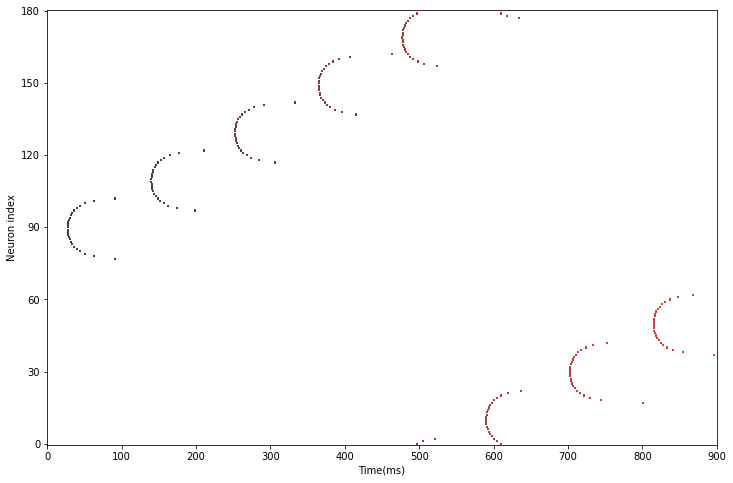

In [15]:
fig, ax = plt.subplots(figsize = (12,8))
for i_scan, t_start in enumerate(np.linspace(0, simtime_show, N_scan)):
    sim.setup(timestep=dt)
    print(f'{t_start=:.1f}')
    spike_source = celebrini(N_inputs, t_starts=[t_start], theta=i_scan/N_scan+1/2, verbose=False)
    spike_in = sim.Population(N_inputs, spike_source)
    spike_in.record('spikes')

    # === Run simulation ===========================================================
    sim.run(simtime)
    sim.end()
    spiketrains = spike_in.get_data().segments[0].spiketrains
    fig, ax = plot_spiketrains(spiketrains, color=(i_scan/N_scan, 0, 0), simtime_show=simtime_show, fig=fig, ax=ax)


## adding more stimulations

t_start=0.0
t_start=112.5
t_start=225.0
t_start=337.5
t_start=450.0
t_start=562.5
t_start=675.0
t_start=787.5
t_start=900.0


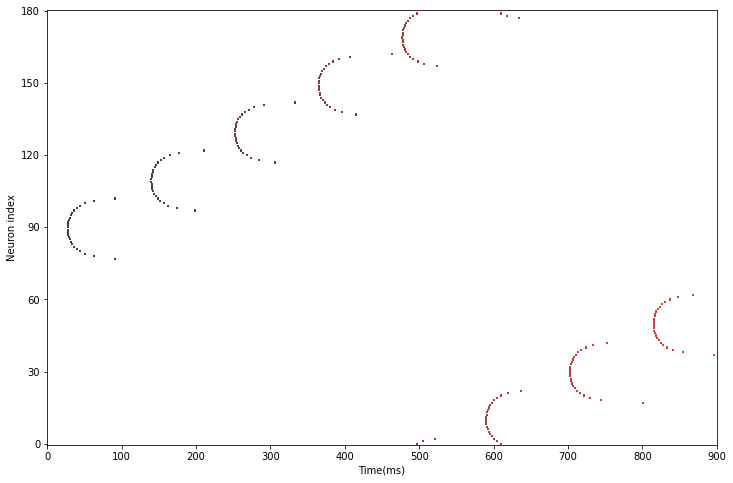

In [16]:
fig, ax = plt.subplots(figsize = (12,8))
for i_scan, t_start in enumerate(np.linspace(0, simtime_show, N_scan)):
    sim.setup(timestep=dt)
    print(f'{t_start=:.1f}')
    spike_source = celebrini(N_inputs, t_starts=[t_start], theta=i_scan/N_scan+1/2, verbose=False)
    spike_in = sim.Population(N_inputs, spike_source)
    spike_in.record('spikes')

    # === Run simulation ===========================================================
    sim.run(simtime)
    sim.end()
    spiketrains = spike_in.get_data().segments[0].spiketrains
    fig, ax = plot_spiketrains(spiketrains, color=(i_scan/N_scan, 0, 0), simtime_show=simtime_show, fig=fig, ax=ax)
